In [1]:
import numpy as np

In [6]:
class AffineTransformationLayer:
    def __init__(self, input_size, output_size, weight_initializer, random_init_scaler=True):
        self.input_size = input_size
        self.output_size = output_size
        if weight_initializer == 'zeros':
            self.weights = np.zeros((input_size, output_size))
            self.bias = np.zeros((1, output_size))
        elif weight_initializer == 'random_init':
            self.weights = np.random.random((input_size, output_size))
            self.bias = np.random.random((1, output_size))
            if random_init_scaler:
                self.weights = self.weights / np.sqrt(input_size + output_size)
                self.bias = self.bias / np.sqrt(input_size + output_size)
        elif weight_initializer == 'normal_init':
            self.weights = np.random.normal(0, 0.1, (input_size, output_size))
            self.bias = np.random.normal(0, 0.1, (1, output_size))

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [7]:
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

In [8]:
class Reshaping_Layer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))
    
    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

In [9]:
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')

def leaky_relu(x):
    return np.maximum(x, 0.01 * x)

def leaky_relu_prime(x):
    return np.array(x >= 0).astype('int') + 0.01 * np.array(x < 0).astype('int')

def linear(x):
    return x

def linear_prime(x):
    return np.ones(x.shape)

In [11]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mae_prime(y_true, y_pred):
    return np.sign(y_pred - y_true) / y_pred.size

def cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))

def cross_entropy_prime(y_true, y_pred):
    return -y_true / y_pred

In [8]:
from utils import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, y_train, x_test, y_test = load_mnist()

# Normalize the images.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train[:10000]
y_train = y_train[:10000]

# Flatten the images.
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# One hot encode the labels.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Split the train data into train and validation sets.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [4]:
class NeuralNetwork:
    def __init__(self, n_inputs,  input_shape, hidden_layer_sizes, n_outs, activation_fn, activation_fn_derivative, weight_initialization, loss, loss_prime):
        self.network = []
        self.network.append(Reshaping_Layer(input_shape))
        # Input To Hidden
        self.network.append(AffineTransformationLayer(n_inputs, hidden_layer_sizes[0], weight_initialization))
        self.network.append(ActivationLayer(activation_fn, activation_fn_derivative))
        # Hidden To Hidden
        for i in range(len(hidden_layer_sizes) - 1):
            self.network.append(AffineTransformationLayer(hidden_layer_sizes[i], hidden_layer_sizes[i+1], weight_initialization))
            self.network.append(ActivationLayer(activation_fn, activation_fn_derivative))
        # Hidden To Output
        self.network.append(AffineTransformationLayer(hidden_layer_sizes[-1], n_outs, weight_initialization))
        self.network.append(SoftmaxLayer(n_outs))
        self.loss = loss
        self.loss_prime = loss_prime
        self.train_loss = []
        self.val_loss = []
    
    def predict(self, x):
        for layer in self.network:
            x = layer.forward(x)
        return x
    
    def fit(self, x_train, y_train, x_valid, y_valid, epochs=1000, learning_rate=0.1, batch_size=32, early_stopping=True, patience=10, verbose=True):
        x_batches_train = np.array_split(x_train, len(x_train)/ batch_size)
        y_batches_train = np.array_split(y_train, len(y_train)/ batch_size)
        for epoch in range(epochs):
            error = 0
            error_val = 0
            for x_train, y_train in zip(x_batches_train,y_batches_train):
                for x, y_true in zip(x_train, y_train):

                    output = x
                    
                    output = self.forward(output)

                    error += self.loss(y_true, output)

                    output_error = self.loss_prime(y_true, output)

                    self.backward(output_error, learning_rate)

                    error /= len(x_train)

            error_val = sum([self.loss(y, self.predict(x)) for x, y in zip(x_valid, y_valid)]) / len(x_valid) 

            self.train_loss.append(error)
            self.val_loss.append(error_val)

            if early_stopping:
                if epoch > patience:
                    if self.train_loss[-1] > np.mean(self.val_loss[-(patience+1):-1]):
                        print('Early Stopping')
                        break
            if verbose:
                if epoch % 10 == 0:
                    print(f"Epoch: {epoch}, Training Loss: {error}, Validation Loss: {error_val}")

    def forward(self, x):
        for layer in self.network:
            x = layer.forward(x)
        return x

    def backward(self, output_error, learning_rate):
        for layer in reversed(self.network):
            output_error = layer.backward(output_error, learning_rate)

    def predict_proba(self, x):
        return self.predict(x)

    def score(self, x, y):
        cnt = 0
        for x_v, y_v in zip(x,y):
            op = self.predict(x_v)
            if (np.argmax(op) == np.argmax(y_v)):
                cnt+=1
        return cnt/y.shape[0]

In [2]:
def save_model(model, filename):
    import pickle
    with open(f"Model_Saves/{filename}", 'wb') as f:
        pickle.dump(model, f)

def load_model(filename):
    import pickle
    with open(f"Model_Saves/{filename}", 'rb') as f:
        return pickle.load(f)

In [11]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((8000, 784), (8000, 10), (2000, 784), (2000, 10))

In [12]:
activation_fns = [relu, sigmoid, tanh, leaky_relu, linear]
activation_fns_prime = [relu_prime, sigmoid_prime, tanh_prime, leaky_relu_prime, linear_prime]

In [14]:
for activation_fn, activation_fn_prime in zip(activation_fns, activation_fns_prime):
    print(f"Activation Function: {activation_fn.__name__}")
    model = NeuralNetwork(784, (28,28), [256,128,64,32], 10, activation_fn, activation_fn_prime, 'normal_init', mse, mse_prime)
    model.fit(x_train, y_train, x_val, y_val, epochs=100, learning_rate=0.001, batch_size=128, early_stopping=True, patience=10, verbose=True)
    print(f"Accuracy: {model.score(x_test, y_test)}")
    save_model(model, f"model_{activation_fn.__name__}.pkl")

Activation Function: relu
Epoch: 0, Training Loss: 0.0006926952076625672, Validation Loss: 0.08987083738288432
Epoch: 10, Training Loss: 0.0004886420801814411, Validation Loss: 0.08025524917728491
Epoch: 20, Training Loss: 0.0002910827704302052, Validation Loss: 0.04729564473916273
Epoch: 30, Training Loss: 0.00022309467777434735, Validation Loss: 0.026681221408507413
Epoch: 40, Training Loss: 0.0002483548818066395, Validation Loss: 0.020125978557046443
Epoch: 50, Training Loss: 0.00019106551210929955, Validation Loss: 0.017290346330173952
Epoch: 60, Training Loss: 0.00014229941190942362, Validation Loss: 0.01581425884628157
Epoch: 70, Training Loss: 0.00011446359812789067, Validation Loss: 0.014881210616549763
Epoch: 80, Training Loss: 0.00010140715103460584, Validation Loss: 0.0142126615987349
Epoch: 90, Training Loss: 9.370510232731414e-05, Validation Loss: 0.013680512473825214
Accuracy: 0.9163
Activation Function: sigmoid
Epoch: 0, Training Loss: 0.0007028043590856087, Validation L

In [13]:
initialization_fns = ['zeros', 'normal_init', 'random_init']

In [14]:
for initialization_fn in initialization_fns:
    print(f"Initialization Function: {initialization_fn}")
    model = NeuralNetwork(784, (28,28), [256,128,64,32], 10, tanh, tanh_prime, initialization_fn, mse, mse_prime)
    model.fit(x_train, y_train, x_val, y_val, epochs=20, learning_rate=0.001, batch_size=128, early_stopping=True, patience=10, verbose=True)
    print(f"Accuracy: {model.score(x_test, y_test)}")
    save_model(model, f"model_{initialization_fn}_activation_tanh.pkl")

Initialization Function: zeros
Epoch: 0, Training Loss: 0.000703199131626078, Validation Loss: 0.08999940704711566
Epoch: 10, Training Loss: 0.0007038801296823434, Validation Loss: 0.08999536889248395
Accuracy: 0.1135
Initialization Function: normal_init
Epoch: 0, Training Loss: 0.0007329035100623313, Validation Loss: 0.08916043917219324
Epoch: 10, Training Loss: 0.0006916599637221394, Validation Loss: 0.07107287207220907


In [26]:
# Load Relu Model
relu_model = load_model("model_relu.pkl")
# Load Sigmoid Model
sigmoid_model = load_model("model_sigmoid.pkl")
# Load Tanh Model
tanh_model = load_model("model_tanh.pkl")
# Load Leaky Relu Model
leaky_relu_model = load_model("model_leaky_relu.pkl")
# Load Linear Model
linear_model = load_model("model_linear.pkl")

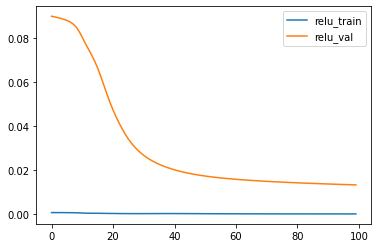

In [27]:
import matplotlib.pyplot as plt
# Plot the loss for all the models
plt.plot(relu_model.train_loss, label='relu_train')
plt.plot(relu_model.val_loss, label='relu_val')
plt.legend()
plt.show()

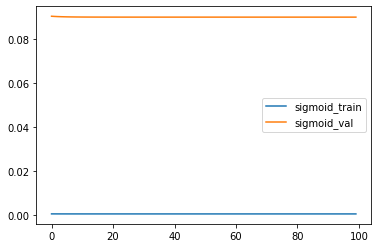

In [18]:
import matplotlib.pyplot as plt
# Plot the loss for all the models
plt.plot(sigmoid_model.train_loss, label='sigmoid_train')
plt.plot(sigmoid_model.val_loss, label='sigmoid_val')
plt.legend()
plt.show()

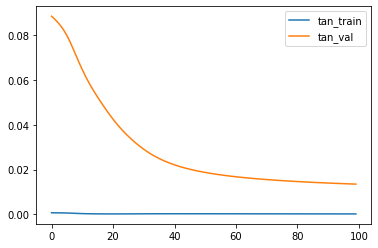

In [19]:
import matplotlib.pyplot as plt
# Plot the loss for all the models
plt.plot(tanh_model.train_loss, label='tan_train')
plt.plot(tanh_model.val_loss, label='tan_val')
plt.legend()
plt.show()

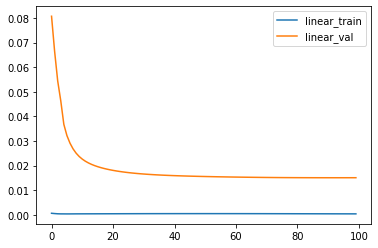

In [28]:
import matplotlib.pyplot as plt
# Plot the loss for all the models
plt.plot(linear_model.train_loss, label='linear_train')
plt.plot(linear_model.val_loss, label='linear_val')
plt.legend()
plt.show()

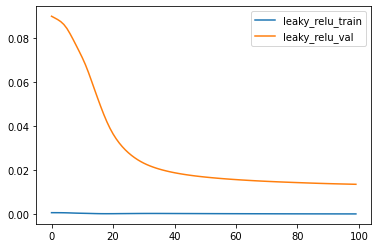

In [20]:
import matplotlib.pyplot as plt
# Plot the loss for all the models
plt.plot(leaky_relu_model.train_loss, label='leaky_relu_train')
plt.plot(leaky_relu_model.val_loss, label='leaky_relu_val')
plt.legend()
plt.show()

In [24]:
# Load Zeros Model
zeros_model = load_model("model_zeros_activation_tanh.pkl")
# Load Normal Init Model
normal_init_model = load_model("model_normal_init_activation_tanh.pkl")
# Load Random Init Model
random_init_model = load_model("model_random_init_activation_tanh.pkl")

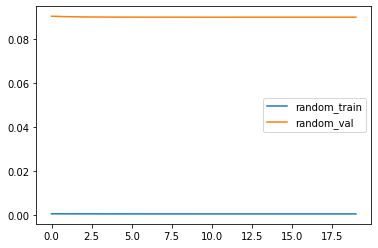

In [25]:
# Plot the loss for all the models
plt.plot(random_init_model.train_loss, label='random_train')
plt.plot(random_init_model.val_loss, label='random_val')
plt.legend()
plt.show()

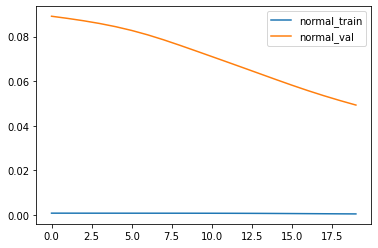

In [23]:
# Plot the loss for all the models
plt.plot(normal_init_model.train_loss, label='normal_train')
plt.plot(normal_init_model.val_loss, label='normal_val')
plt.legend()
plt.show()

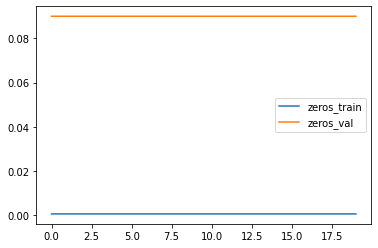

In [22]:
# Plot the loss for all the models
plt.plot(zeros_model.train_loss, label='zeros_train')
plt.plot(zeros_model.val_loss, label='zeros_val')
plt.legend()
plt.show()